## ERA5 Compute Fluxes
This notebook loads in (via GCP) the ERA5 dataset at $1.5\degree$ resolution and coarsens it in time to 4x daily (6 hourly). 

It then runs the AD99 offline parameterization over the data to predict both the zonal and meridional momentum fluxes before saving it to the drive

## dask/SLURM Setup
This is optional and configured for the Sherlock HPC at Stanford. For large operations multiprocessing will speed this up drastically though the operation can be completed on a single laptop (albiet very slowly).

In [1]:
from dask_jobqueue import SLURMCluster
NCORES = 8
NPROCESS = 8
NCORESPERPROCESS = NCORES//NPROCESS
constraints = ['-C \"CLASS:SH4_CBASE|CLASS:SH4_CPERF\"'] # SH4 nodes are the fastest, and mixing node gens seems to cause ib0 issues.
cluster = SLURMCluster(queue='serc',memory='96GiB',cores=NCORES,processes=NPROCESS,walltime='06:00:00',job_extra_directives=constraints,log_directory='/scratch/users/robcking/dask_worker_logs')
cluster.scale(jobs=50) # roughly but tune to scheduler 
cluster



/home/groups/aditis2/robcking/condaenvs/ad99py/lib/python3.13/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34725 instead
  warnings.warn(


Dashboard: http://10.20.8.24:34725/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.20.8.24:43691,Workers: 0
Dashboard: http://10.20.8.24:34725/status,Total threads: 0
Started: Just now,Total memory: 0 B


Setup dask distributed client

In [2]:
from dask.distributed import Client 
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.20.8.24:34725/status,
Dashboard: http://10.20.8.24:34725/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.20.8.24:43691,Workers: 0
Dashboard: http://10.20.8.24:34725/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Load data

In [1]:
import xarray as xr 
import matplotlib.pyplot as plt 
import numpy as np 
import dask.array as da
import cartopy.crs as ccrs 

PATH_COARSE = 'gs://gcp-public-data-arco-era5/ar/1959-2022-1h-240x121_equiangular_with_poles_conservative.zarr'
ds = xr.open_zarr(PATH_COARSE,chunks={})
ds_4xdaily = ds.sel(time=slice('2014-01-01',None,6))
ds_4xdaily = ds_4xdaily.isel(level=slice(None,None,-1))
ds_4xdaily

KeyboardInterrupt: 

In [4]:
variables = ['u_component_of_wind','v_component_of_wind','temperature','geopotential']
ds_4xdaily_reduce = ds_4xdaily[variables]
ds_4xdaily_reduce = ds_4xdaily_reduce.transpose("time","longitude","latitude","level")
ds_4xdaily_reduce = ds_4xdaily_reduce.chunk({'time':1})

Diagnostic visualization of temperature to check data loading working as anticipated

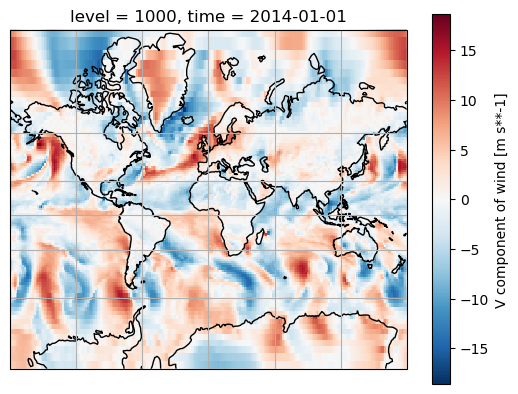

In [5]:
ax = plt.axes(projection=ccrs.Mercator())
ds_4xdaily_reduce.v_component_of_wind.isel(time=0,level=0).plot(ax=ax,x='longitude',y='latitude',transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()

In [6]:
from ad99py import GRAV,C_P,BFLIM,R_DRY

us = ds_4xdaily_reduce.u_component_of_wind
vs = ds_4xdaily_reduce.v_component_of_wind
temps = ds_4xdaily_reduce.temperature
height = ds_4xdaily_reduce.geopotential / GRAV

dTdz = da.gradient(temps,axis=-1)/da.gradient(height,axis=-1)
Ns2 = GRAV/temps*(dTdz + GRAV/C_P) 
Ns2 = da.where(Ns2 < BFLIM ** 2, BFLIM **2 , Ns2 )
Ns = Ns2 ** 0.5 
rho = (100*temps.level.data.astype(np.float32)[None,None,None,:]/(R_DRY*temps))

lat = da.broadcast_to(ds_4xdaily_reduce.latitude.data[None,None,:],us.shape[:-1]).astype(np.float32)
lat = lat.rechunk((1,-1,-1,))

Persist all data into the cluster (reduces the length of the dask graph for the next step)

In [7]:
import dask 
from dask.distributed import wait,progress

us,vs,height,Ns,rho = dask.persist(us,vs,height,Ns,rho)
us =us.data
vs = vs.data
rho = rho.data
height = height.data


## Get latitude into the correct broadcasted form for AD99
lat_4d = lat[..., None]         # now shape = (11688, 240, 121, 1)
lat_4d = lat_4d.rechunk((1,-1,-1,-1)).persist() 

wait(us)
wait(vs)
wait(Ns)
wait(rho)
wait(height)

/home/groups/aditis2/robcking/condaenvs/ad99py/lib/python3.13/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 14.74 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


DoneAndNotDoneFutures(done={<Future: finished, type: numpy.ndarray, key: ('truediv-5f7f2e72a819f4482d424f235331ca88', 10951, 0, 0, 0)>, <Future: finished, type: numpy.ndarray, key: ('truediv-5f7f2e72a819f4482d424f235331ca88', 136, 0, 0, 0)>, <Future: finished, type: numpy.ndarray, key: ('truediv-5f7f2e72a819f4482d424f235331ca88', 4841, 0, 0, 0)>, <Future: finished, type: numpy.ndarray, key: ('truediv-5f7f2e72a819f4482d424f235331ca88', 3016, 0, 0, 0)>, <Future: finished, type: numpy.ndarray, key: ('truediv-5f7f2e72a819f4482d424f235331ca88', 7572, 0, 0, 0)>, <Future: finished, type: numpy.ndarray, key: ('truediv-5f7f2e72a819f4482d424f235331ca88', 3743, 0, 0, 0)>, <Future: finished, type: numpy.ndarray, key: ('truediv-5f7f2e72a819f4482d424f235331ca88', 11256, 0, 0, 0)>, <Future: finished, type: numpy.ndarray, key: ('truediv-5f7f2e72a819f4482d424f235331ca88', 1451, 0, 0, 0)>, <Future: finished, type: numpy.ndarray, key: ('truediv-5f7f2e72a819f4482d424f235331ca88', 9611, 0, 0, 0)>, <Future:

In [8]:
from ad99py import AlexanderDunkerton1999
ad99 = AlexanderDunkerton1999(Fs0=4.3e-3,cw=35,exclude_unbroken=False,use_intrinsic_c=10.0) # this is following the MiMA spec


def dask_ad99_map_block(ublock,Nblock,zblock,rhoblock,latblock):
    """
    Map indivudal blocks by linearly running them through the parameterization. 
    Not very fast or efficient right now but could be optimized further in future
    """
    batch_shape = ublock.shape[:-1]
    nlevels = ublock.shape[-1]
    
    ublock_flt = ublock.reshape((-1,nlevels))
    Nblock_flt = Nblock.reshape((-1,nlevels))
    zblock_flt = zblock.reshape((-1,nlevels))
    rhoblock_flt = rhoblock.reshape((-1,nlevels))
    latblock_flt = latblock.ravel()
    results = np.array([
        ad99.momentum_flux_neg_ptv(u,N,z,rho,lat) for u,N,z,rho,lat in zip(ublock_flt,Nblock_flt,zblock_flt,rhoblock_flt,latblock_flt)
    ])
    
    result_shp = results.reshape((*batch_shape,2,nlevels))
    result_rtn = np.moveaxis(result_shp,-2,-1)
    return result_rtn 

/home/groups/aditis2/robcking/ad99py/src/ad99py/ad99.py:65: UserWarning: `source` is not set, using default Gaussian source spectrum, with `cw=35` and `Bm=0.4`.
  warn(f"`source` is not set, using default Gaussian source spectrum, with `cw={cw}` and `Bm={Bm}`.")


Write core data

In [9]:
dims = ('time','longitude','latitude','level')
coords={
    'time':('time',ds_4xdaily_reduce.time.values),
    'longitude':('longitude',ds_4xdaily_reduce.longitude.values),
    'latitude':('latitude',ds_4xdaily_reduce.latitude.values),
    'level':('level',ds_4xdaily_reduce.level.values)
}
ds_data = xr.Dataset({
    'u':(dims,us),
    'v':(dims,vs),
    'Ns':(dims,Ns),
    'z':(dims,height),
    'rho':(dims,rho)},coords=coords,attrs={
        'ad99_intrinsic_c_settings':10.0,
        'ad99_Bt':4.3e-3,
        'ad99_cw':35,
        'ad99_Bm':0.4,
        'ad99_exclude_unbroken':0,
        'ad99_source':'gaussian'
    })

expname='10_include_unbroken'
OUTPUT_PATH = f'/scratch/users/robcking/era5_{expname}.zarr'
ds_data.to_zarr(OUTPUT_PATH,mode='w',zarr_format=2)

/home/groups/aditis2/robcking/condaenvs/ad99py/lib/python3.13/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 10.99 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


zonal direction operations

In [10]:
result_u = da.map_blocks(
    dask_ad99_map_block,
    us,Ns,height,
    rho,
    lat_4d,
    new_axis=len(us.shape),
    dtype=us.dtype,
    chunks=tuple(c[0] for c in us.chunks) + (2,)).persist()



In [11]:
ntv_u_flux = result_u[...,0]
ptv_u_flux = result_u[...,1]
ds_data = xr.Dataset({
    'gw_flux_westward':(dims,ntv_u_flux),
    'gw_flux_eastward':(dims,ptv_u_flux),
},coords=coords)
ds_data.to_zarr(OUTPUT_PATH,mode='a',zarr_format=2)

In [12]:
result_v = da.map_blocks(
    dask_ad99_map_block,
    vs,Ns,height,
    rho,
    lat_4d,
    new_axis=len(vs.shape),
    dtype=vs.dtype,
    chunks=tuple(c[0] for c in vs.chunks) + (2,)).persist()
ntv_v_flux = result_v[...,0]
ptv_v_flux = result_v[...,1]

Meridional Direction ops

In [13]:
ds_data = xr.Dataset({
    'gw_flux_northward':(dims,ptv_v_flux),
    'gw_flux_southward':(dims,ntv_v_flux)
},coords=coords)
ds_data.to_zarr(OUTPUT_PATH,mode='a',zarr_format=2)
